# Part 0: Import modules

In this part every module that is used is initialized along with defining files and directories that are used to load data.

In [5]:
from collections import Counter, OrderedDict # counting elements and ordering keys in dictionaries
import community # python-louvain package
from __future__ import division # all numbers are float
from infomap import infomap # python infomap algorithm
import math # math operations
from matplotlib import pyplot as plt # plotting
import networkx as nx # graph library
import nltk # natural language toolkit
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import numpy as np # array operations
import operator # efficient operator functions
import os # folder operations
import pandas as pd # use easy-to-use data frames for data analysis
import pickle # python data structures asa files
import re # regex
import requests # get text from URL
import scipy.stats as stats
import tarfile # extract tar.gz files
import urllib # get file from URL and save to disk

In [7]:
# display plots in IPython cell
%matplotlib inline

# directory to load philosophers graph from
p_directory = os.getcwd() + '/../philosophers'

# directory to save wikispeedia dataset too
w_directory = os.getcwd() + '/../wikispeedia'
# create if necessary
if not os.path.exists(w_directory):
    os.makedirs(w_directory)
# downloaded files
text_file = 'texts.tar.gz'
network_file = 'network.tar.gz'

# download nltk data if necessary (e.g.: stopwords)
nltk.download()

# specify nltk data dir, otherwise LookupError error
nltk.data.path.append(os.getcwd() + '/../nltk_data')

# import all novels after updated path
from nltk.book import *

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


# Part I: Advanced Network Structure

We start by looking at the structure of the the philosopher network using the more complicated network measures. If your network has more than one component, just work on the _giant connected component_ (GCC) in the exercises below (in a directed graph use the [_weakly_ connected component](https://networkx.github.io/documentation/networkx-1.9.1/reference/algorithms.component.html)).

The network is recreated from a previously saved binary pickle file that will load a Python dictionary.

In [180]:
# get data dictionary
with open('{0}/dat.pkl'.format(p_directory), 'rb') as f:
    dat = pickle.load(f)

Each key in the dictionary equals a node name and will be added as list to the directed graph.

In [181]:
# create one node per philosopher name (keys of data)
p_graph = nx.DiGraph()
p_graph.add_nodes_from(dat.keys()) 

The links are created iteratively for each wiki markup link in the extracted text. As and example in and out links from and to other philosophers to Immanuel Kant are shown.

In [182]:
# create node links
for p in dat:
    p_content = dat[p]
    # find all wiki links in the content
    p_links = re.findall(r'\[\[(.+?)\]\]', p_content)
    # list with all outgoing links for edges
    # decode unicode chars and clean the link for matching
    out_links = [l.decode('unicode-escape').split('|')[0].replace(' ', '_') for l in p_links]

    # intersection between all philosophers and found links in article
    all_edges = set(dat.keys()).intersection(out_links)
    # show example of related philosophers
    if p == 'Immanuel_Kant':
        print all_edges

    # add an edge for the philosopher
    for e in all_edges:
        p_graph.add_edge(p, e)

set([u'Jean_Piaget', u'Johann_Gottfried_Herder', u'Friedrich_Wilhelm_Joseph_von_Schelling', u'August_Wilhelm_Schlegel', u'Baruch_Spinoza', u'Roger_Scruton', u'John_Locke', u'Ren\xe9_Descartes', u'Gotthold_Ephraim_Lessing', u'Robert_Nozick', u'Plato', u'John_McDowell', u'Arthur_Schopenhauer', u'Jean-Jacques_Rousseau', u'Houston_Stewart_Chamberlain', u'Nicolai_Hartmann', u'Gottfried_Leibniz', u'David_Hilbert', u'Christian_Wolff_(philosopher)', u'P._F._Strawson', u'Epicurus', u'Gilles_Deleuze', u'Bertrand_Russell', u'Georg_Simmel', u'Friedrich_Nietzsche', u'Michel_Foucault', u'Alexander_Gottlieb_Baumgarten', u'Thomas_Henry_Huxley', u'Wilhelm_Dilthey', u'Charles_Sanders_Peirce', u'David_Hume', u'John_Rawls', u'S\xf8ren_Kierkegaard', u'Christine_Korsgaard', u'C._D._Broad', u'Georg_Wilhelm_Friedrich_Hegel', u'Martin_Heidegger', u'Derek_Parfit', u'Noam_Chomsky', u'Aristotle', u'Adam_Smith', u'J\xfcrgen_Habermas', u'Joxe_Azurmendi'])


Look how many components our graph has. If weakly connected components greater than 1 work on WCC subgraph with biggest length.

In [204]:
print "The number of weakly connected components:", nx.number_weakly_connected_components(p_graph)

# weakly connected components as subgraphs
p_sub = sorted(nx.weakly_connected_component_subgraphs(p_graph), key=len, reverse=True)

# extract biggest
p_wcc = p_sub[0]
print 'The size (number of nodes) of subgraph with largest weakly connected component is:', p_wcc.size()

The number of weakly connected components: 194
The size (number of nodes) of subgraph with largest weakly connected component is: 4439


Not all of the measures we'll be considering below are defined for directed graphs, thus begin by creating an [undirected version](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.DiGraph.to_undirected.html) of the philosopher graph, that we can use whenever needed. Only use the undirected graph when explicitly stated in the exercise.

In [187]:
# create undirected version
p_wcc_undir = p_wcc.to_undirected()

**Question:** Find the 5 most central philosophers according to [betweenness centrality](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html).

The betweenness centrality can be calculated on the direct graph. The function returns a dictionary where every key is a node with the betweenness centrality as the value.

**Answer:**

In [188]:
# calculate betweenness centrality
node_dict = nx.betweenness_centrality(p_wcc)

# use to print with betweenness_centrality
print Counter(node_dict).most_common(5)
# and without
#print sorted(node_dict, key=node_dict.get, reverse=True)[:5]

[(u'Immanuel_Kant', 0.09125801689671491), (u'Bertrand_Russell', 0.0767049256243864), (u'David_Hume', 0.05693823847812551), (u'Plato', 0.05506094814276283), (u'Aristotle', 0.054364534358649894)]


**Question:** What role do you imagine philosophers with high wikipedia graph betweenness centrality play in the history of philosophy?

**Answer:** Betweenness centrality indicates the centrality of a node (philosopher) in the network. It is equal to the number of shortest paths from all nodes to all others that pass through that node. Philosophers with a high betweenness centrality probably act as a intermediary scholar who boosts the communication (links) between other scholars. It is pretty obvious that the most common philosophers wrote multiple literature and developed core theories.

**Question:** Find the 5 most central philosophers according to [eigenvector centrality](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.centrality.eigenvector_centrality.html). Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 

The eigenvector centrality can be evaluated with a similar function to the betweenness centrality. It makes sense however to differentiate between in- and out-edges.

**Answer:**

In [189]:
### eigenvector centrality
# in-edges
node_in_eigen = nx.eigenvector_centrality(p_wcc)
# For out-edges eigenvector centrality first reverse the graph with G.reverse().
node_out_eigen = nx.eigenvector_centrality(p_wcc.reverse())

print "5 most central philosophers according to in-edges eigenvector centrality:"
print sorted(node_in_eigen, key=node_in_eigen.get, reverse=True)[:5]

print "\n5 most central philosophers according to out-edges eigenvector centrality:"
print sorted(node_out_eigen, key=node_out_eigen.get, reverse=True)[:5]

5 most central philosophers according to in-edges eigenvector centrality:
[u'Immanuel_Kant', u'Aristotle', u'Bertrand_Russell', u'Plato', u'Friedrich_Nietzsche']

5 most central philosophers according to out-edges eigenvector centrality:
[u'Georg_Wilhelm_Friedrich_Hegel', u'Martin_Heidegger', u'Friedrich_Nietzsche', u'Immanuel_Kant', u'Michel_Foucault']


For comparison the degree centrality is calculated.

In [190]:
### degree centrality
# in-edges
node_in_degree = nx.degree_centrality(p_wcc)
# out-edges
node_out_degree = nx.degree_centrality(p_wcc.reverse())

print "in-edges degree centrality: ", sorted(node_in_degree, key=node_in_degree.get, reverse=True)[:5]
print "out-edges degree centrality: ", sorted(node_out_degree, key=node_out_degree.get, reverse=True)[:5]

in-edges degree centrality:  [u'Immanuel_Kant', u'Aristotle', u'Bertrand_Russell', u'Plato', u'Friedrich_Nietzsche']
out-edges degree centrality:  [u'Immanuel_Kant', u'Aristotle', u'Bertrand_Russell', u'Plato', u'Friedrich_Nietzsche']


**Question:** How is eigenvector centrality difference from degree centrality?

**Answer:** Differences eigenvector and degree centrality:
* The out-edges eigenvector centrality result shows a different behavior from either degree centrality.
* Eigenvector centrality is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. The difference between in- and out-edges is just the direction in the directed graph. A result from week 4 showed that Hegel had the most out-egdes and Kant the most in-edges.
* Historically first and conceptually simplest is degree centrality, which is defined as the number of links incident upon a node (e.g.: the number of ties that a node has). The degree can be interpreted in terms of the immediate risk of a node for catching whatever is flowing through the network (such as a virus, or some information). In the case of a directed network (where ties have direction), usually two separate measures of degree centrality are defined, namely in-degree and out-degree.

**Question:** Compare your results for eigenvector centrality to the results for betweenness centrality - does the difference make sense when you read the philosopher's wikipedia pages?

**Answer:** Comparison of eigenvector centrality to betweenness centrality:
* Aristotle's eigenvector centrality indicates he is not as linked considering the out-edges.
* Nietzsche appears in the 5th spot with eigenvector centrality replacing David Hume in the top 5 of betweenness centrality.
* Betweenness is a centrality measure of a node within a graph. Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.
* Eigenvector centrality accounts for the 'importance' of a node by taking into account the 'importance' of nodes to which it is pointing to (out-edges) or which are pointing at the node (in-edges). Thus it takes more into account than the betweenness centrality.
* So Aristotle maybe builds many bridges with other philosophers but not as many refer to him but the in-edges are still so many that he appears in the top 5 of betweenness centrality. Kant on the other hand builds his paths with the more important philosophers in- and outwards in the network (thus appears in all centrality measures).

**Question:** Is the _undirected version_ of the graph [assortative with respect do degree](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html#networkx.algorithms.assortativity.degree_assortativity_coefficient)? (e.g. do high-degree philosophers tend to link to other high-degree philosophers, and low-degree philosophers to other low-degree philosophers?). Provide an interpretation of your answer!

In [191]:
print "Graph assortativity:", nx.degree_assortativity_coefficient(p_wcc_undir)

Graph assortativity: -0.0742180950406


**Answer:** Assortativity measures the similarity of connections in the graph with respect to the node degree. Since the graph assortativity is negative the guess is that the connections of nodes with similar node degrees rather differ from each other and have not many similarities. In contrast nodes of different degree are more similar. In general positive values indicate a correlation between nodes of similar degree, while negative values indicate relationships between nodes of different degree.

We will now run community detection on the full philosopher network.

To detect communities and calculate the modularity a set of _six new branches_ was created. All of the philosophers that belong to more than one branch are taken and assigned to the branch that they have the most connections to.

In [192]:
# get category dictionary data
with open('{0}/cat.pkl'.format(p_directory), 'rb') as f:
    cat = pickle.load(f)
# key all not needed
del cat['all']

In [193]:
# list of philosophers in more than one branch
cnt = Counter()
for x in cat:
    for i in cat[x]:
        cnt[i] += 1
p_multi = [x for x in cnt if cnt[x] > 1]

In [194]:
# delete those that occur multiple times
p_single = dict()
for key, val in cat.iteritems():
    p_single[key] = set([x for x in val if x not in p_multi])

# the six branches with philosophers occuring once in branch
for key, val in cat.iteritems():
    print 'Number of all philosophers in {0}: {1} - only in this branch and no other branches are: {2} philosophers'.format(
        key, len(cat[key]), len(p_single[key]))

Number of all philosophers in aestheticians: 126 - only in this branch and no other branches are: 102 philosophers
Number of all philosophers in logicians: 271 - only in this branch and no other branches are: 242 philosophers
Number of all philosophers in epistemologists: 99 - only in this branch and no other branches are: 56 philosophers
Number of all philosophers in ethicists: 272 - only in this branch and no other branches are: 206 philosophers
Number of all philosophers in metaphysicians: 96 - only in this branch and no other branches are: 54 philosophers
Number of all philosophers in social_and_political_philosophers: 295 - only in this branch and no other branches are: 233 philosophers


In [195]:
# how many links does each philosopher i has in branch
p_multi_branch_cnt = dict()
for i in p_multi:
    # get number of edges
    links = nx.edges(p_wcc_undir, i)
    # init count 
    p_multi_branch_cnt[i] = {x:0 for x in p_single.keys()}
    # edge list contains (i, other philosopher)
    for l in links:
        # look in what branch
        for key, val in cat.iteritems():
            if l[1] in val:
                p_multi_branch_cnt[i][key] += 1
    # now get the maximum (this ignores the fact that there are ties)
    max_key = max(p_multi_branch_cnt[i].iteritems(), key=operator.itemgetter(1))[0]
    # add the philosopher to branch that it has most connections to
    p_single[max_key].add(i)

In [196]:
test_p = 'Abraham_Joshua_Heschel'
print "An example of link list for {0}: {1}".format(test_p, nx.edges(p_wcc_undir, test_p))
print "\nCounts of this philosopher in each branch:", p_multi_branch_cnt[test_p]
if test_p in p_single['ethicists'] and test_p not in p_single['social_and_political_philosophers']:
    print "\nPhilosopher {0} appears only in ethicists list.".format(test_p)

An example of link list for Abraham_Joshua_Heschel: [('Abraham_Joshua_Heschel', u'Martin_Luther_King,_Jr.'), ('Abraham_Joshua_Heschel', u'Martin_Buber'), ('Abraham_Joshua_Heschel', u'Maimonides')]

Counts of this philosopher in each branch: {'aestheticians': 0, 'logicians': 0, 'epistemologists': 0, 'ethicists': 3, 'metaphysicians': 0, 'social_and_political_philosophers': 1}

Philosopher Abraham_Joshua_Heschel appears only in ethicists list.


A new set of non-overlapping branches was created. The modularity  _M_ of the branches-partitioning is calculated as described in the _Network Science_ book, section 9.4), **equation 9.12**.

$$ M = \sum_{c=1}^{n_c} \bigg[\frac{L_c}{L} - \Big(\frac{k_c}{2L}\Big)^2\bigg] $$

In [198]:
### page 383 in Network Science book
L = nx.number_of_edges(p_wcc_undir) # total edges
M = 0

# set of non-overlapping branches
for category, phil in p_single.iteritems():
    edges_branch = nx.edges(p_wcc_undir, phil)
    
    # sum for links of current edge that are also in branch (in community)
    L_c = sum(1 for edge in edges_branch if edge[1] in phil)
    
    # sum for links of current edge that are not in branch (other communities)
    k_c = sum(1 for edge in edges_branch if edge[1] not in phil)

    # use equation 9.12
    in_c = L_c/L
    other_c = pow(k_c/(2*L), 2)
    M_c = in_c-other_c
    M += M_c
    
print "\nModularity of philosopher graph is:", M  


Modularity of philosopher graph is: 0.430897957471


**Question:** Use [the Python Louvain-algorithm implementation](http://perso.crans.org/aynaud/communities/) to find communities in the full philosopher network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the branches as communities? What does this comparison reveal about the branches?

In [199]:
# compute the best partition
partition = community.best_partition(p_wcc_undir)
print "Modularity with Louvain algorithm =", community.modularity(partition, p_wcc_undir)

Modularity with Louvain algorithm = 0.447465980277


The network can be drawn with each node's community having a slightly different color. Unfortunately proper graph visualization in the [NetworkX library is hard](https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html) but the drawing shows the idea.

Number of communities found: 13.0


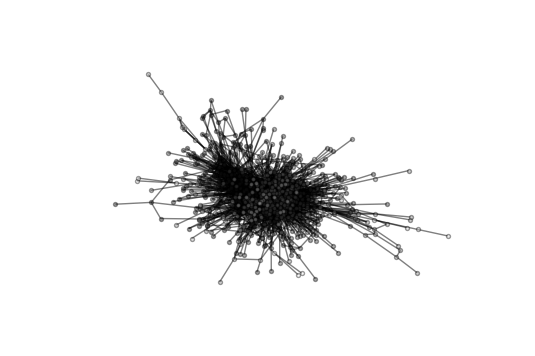

In [216]:
# drawing of communities
size = float(len(set(partition.values())))
print "Number of communities found:", size
pos = nx.spring_layout(p_wcc_undir)
count = 0
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(
        p_wcc_undir, 
        pos, 
        list_nodes, 
        node_size=8, 
        width=0.1, 
        alpha=0.4,
        # string indicates color to differentiate the 13 communities
        node_color=str(count / size)
    )
nx.draw_networkx_edges(p_wcc_undir, pos, alpha=0.5)

plt.axis('off')
plt.show()

You can also try the *Infomap* algorithm instead if you're curious. Go to [this page](http://www.mapequation.org/code.html) and search for 'python'. It's harder to install, but a better community detection algorithm.

Here are the steps on how to install the infomap algorithm:
* Install `swig`, e.g.: sudo apt install swig
* Download the [zip file]() and unpack
* Call `make` in the directory `examples/python`
* Copy the folder into the same directory as your notebook and import the module into the notebook.

By infomap returned top modules are the number of communities.

In [144]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """

    infomapWrapper = infomap.Infomap("--two-level")
    for e in G.edges_iter():
        infomapWrapper.addLink(*e)

    infomapWrapper.run();
    tree = infomapWrapper.tree
    communities = {}
    for node in tree.leafIter():
        communities[node.originalLeafIndex] = node.moduleIndex()

    nx.set_node_attributes(G, 'community', communities)
    return tree.numTopModules()

In [201]:
# the infomap function only accepts integers as node names
p_graph_infomap = nx.convert_node_labels_to_integers(p_wcc_undir)
print "Number of communities found:", findCommunities(p_graph_infomap)

Number of communities found: 49


**Answer**: Modularity of the philosopher graph using our branching method is rounded 0.447 and by Louvain algorithm with modularity maximization it is 0.431. The value for the Louvain algorithm is slightly higher. Modularity shows the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. This comparison reveals that the Louvain algorithm is better since for our given network the partition with maximum modularity corresponds to the optimal community structure.

Even more communities are detected using the infomap algorithm: 13 vs. 49.

Compare the communities found by your algorithm with the branches of philosophy (see [Lecture 5](http://nbviewer.jupyter.org/github/suneman/socialgraphs2016/blob/master/lectures/Week5.ipynb) for details on the branches) by creating a matrix **_D_** with dimension (_B_ times _C_), where _B_ is the number of branches and _C_ is the number of communities. We set entry _D_(_i_,_j_) to be the number of nodes that branch _i_ has in common with community _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix).

The list for each branch and community should be in the same order for a comparison.

In [202]:
# make sure lists are ordered after keys
branches, communities = list(), list()
for key, values in cat.iteritems():
    branches.append(set(cat[key]))
    communities.append(set(p_single[key]))
    
for key, val in cat.iteritems():
    print 'Number of all philosophers in branch {0}: {1} - number of philosophers in community: {2}'.format(
        key, len(cat[key]), len(p_single[key]))

Number of all philosophers in branch aestheticians: 126 - number of philosophers in community: 113
Number of all philosophers in branch logicians: 271 - number of philosophers in community: 264
Number of all philosophers in branch epistemologists: 99 - number of philosophers in community: 66
Number of all philosophers in branch ethicists: 272 - number of philosophers in community: 234
Number of all philosophers in branch metaphysicians: 96 - number of philosophers in community: 58
Number of all philosophers in branch social_and_political_philosophers: 295 - number of philosophers in community: 275


The creation of confusion matrix **_D_** as described in the question.

In [147]:
B = len(branches) # nr. of branches
C = len(communities) # nr. of communities
# create empty matrix with tuple
D = np.zeros((B, C))

# branch i: row, contains all philosophers
# community j: column, contains categorized philosophers after most relevant
for i in range(0, B):
    for j in range (0, C):
        # what branch i has in common with community j
        #print len(set(cat.values()[i])), len(p_single.values()[j]), len(set(cat.values()[i]).intersection(p_single.values()[j]))
        D[i, j] = len(set(branches[i]).intersection(communities[j]))
print D

print 'Accuracy =', np.trace(D)/np.sum(D)

[[ 106.    1.    0.   10.    0.    9.]
 [   2.  259.    1.    4.    0.    2.]
 [   3.    6.   66.   11.    3.   10.]
 [   4.    5.    1.  232.    1.   29.]
 [   4.   14.    9.    8.   57.    4.]
 [   5.    5.    0.   17.    1.  267.]]
Accuracy = 0.853806228374


**Question:** Use the confusion matrix to explain how well the communities you've detected correspond to the labeled branches of philosophy.

**Answer:** The algorithm to detect the communities has an accuracy of about 85% compared to the labeled branches of philosophy. There are few false positives (a philosopher that went into a branch but does not belong there, predicted does belong there but condition is negative) and false negatives (a philosopher that is missing in a branch, predicted does not belong there but condition is positive) in the communities.

# Part II: Human navigation paths 

This exercise works on the wikispeedia dataset. For details on wikispeedia, see [Lecture 8](http://nbviewer.jupyter.org/github/suneman/socialgraphs2016/blob/master/lectures/Week5.ipynb)

### IIa: Path lengths

The first thing we want to take a look at is path lengths. NetworkX allows us to calculate the shortest path between any pair of articles. We begin by comparing the length of human and shortests paths. 

* For each _source_/_target_ pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths. 
* For each _source_/_target_ pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths. 
* How much longer are the human paths on average?
* Create scatter plot where each point is a _source_/_target_ pair, and you have human path lengths on the $x$-axis and shortests paths on the $y$-axis.
* Is there a correlation between human/shortest path-lengths? What is the correlation.

### IIb: Betweenness

An interesting definition of centrality is _betweenness centrality_. In a traditional setting, this measure calculates all shortest paths in the network and then each node gets a score according to which fraction of all shortest paths pass through that node.

In this part of the assignment, we create our own version of centrality, based on the _source_/_target_ pairs in our dataset. We define a nodes's **navigation centrality** as follows. 

> *Navigation centrality* of node $i$ is the fraction of all naviagtion paths that pass through $i$. We exclude the source and target from the count. If a node has not been visited by a search, the navigation centrality of that node is defined to be zero.

Below, we investigate the relationship between navigation centrality and betweenness centrality.

Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset.
Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.

* First, list the 5 pages with highest navigation centrality.
* Second, list the 5 pages with highest betweenness centrality.
* Compare the two lists. Explain the differences between the two lists in your own words.
* Create a scatterplot of betweenness centrality vs. navigation centrality.
* Let's explore the pages that have navigation centrality equal to zero.
  * How many pages have zero navigation centrality?
  * What is the the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).
  * Plot the distribution of betweenness centrality for the pages with zero navigation centrality. 
* Now, let's *throw out all pages with zero navigation centrality* and compare navigation- and betweenness centrality for the remaining pages.
  * What is the correlation between betweenness centrality and navigation centrality?
  * Comment on the top 5 outliers.

### IIc: Bringing the text into the picture

Now that we have an idea about the differences between how humans and computers search in networks, we are going to dig a little deeper using the page content to test a hypothesis to explain why the human navigation paths are longer. The general idea is that humans (who don't know about the global network structure) tend to jump between pages that have related _content_. For this reason we expect that (on average) human navigation paths have more similar content than the shortest paths in the network (which might take 'surprising' shortcuts via relatively unrelated pages). In short.

> **Hypothesis H1**: Human navigation paths have more similar content than network shortest paths.

The way we'll test this hypothesis is to first represent each page as a vector using a bag-of-words approach, then we can calculate a distance between pairs of pages using some vector-space difference, and finally we'll characterize each path by its average pair-wise distance. Below, I've set up that process as an exercise. 

First, create a TF-IDF vector for each page based on the ascii version of the page texts. 

Second, write a function that calculates the distance between a pair of vectors. There are many ways to calculate distances between a pair of vectors (try a Google search for `vector space distance measures` if you want to refresh your knowledge on this topic). You're free to choose what you want, but we recommend the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

Now you're ready to get started

* Calculate the average similarity for all human navigation paths (the _source_/_target_ pairs from above). Calculate mean/variance of these average similarities.
* Calculate the average similarity for all shortest paths between the _source_/_target_ pairs. Calculate mean/variance of these average similarities.
* Plot the distributions of average similarities for both human- and shortest paths in a single plot. If everything works well, you should see something similar to the following:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/path-similarity.png)
* Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.
* Comment on your findings. Is **H1** true?

# Part III

Exercise, sentiment over some books from NLPP1e

Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1).

In [220]:
# get list from website
r = requests.get(
    'http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0026752.s001')

In [259]:
# read into pandas dataframe, skip the header
wordlist = pd.read_csv(cStringIO.StringIO(r.text), sep="\t", skiprows=[0, 1])

print wordlist[0:5]

        word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332  


**Question:** Describe briefly how the list was generated.

**Answer:** According to the abstract the list was collected and evaluated according to the expressions made on Twitter, uncovering and explaining temporal variations in happiness.

Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc). The function should complain if there are no words with sentiment attached.

In [257]:
# create a WordNetLemmatizer for stemming the tokens
wl = WordNetLemmatizer() 

# load english stop words
stopwords = nltk.corpus.stopwords.words('english')

# calculates a sentiment on given text and wordlist with happiness averages
def calc_sentiment(tokens, happiness_words):
    w_sum = 0
    w_total = 0
    # convert tokenlist
    cleaned_tokens = [wl.lemmatize(w.lower()) for w in tokens if len(w) > 2 and w.isalpha() and w not in stopwords]
    for word in cleaned_tokens:
        if word in happiness_words:
            w_total += 1
            avg = happiness_words[word]
            # check for valid number
            if isinstance(avg, np.float64): 
                w_sum += avg
    if w_total > 0:
        sentiment_val = w_sum / w_total 
    else:
        # uncomment to see the complaints, if there are no words with sentiment attached.
        #print 'There are no words with sentiment attached!'
        return 0
    return sentiment_val 

In [253]:
# convert the wordlist to dict with word: happiness_average as key: value pairs
happiness_words = pd.Series(wordlist.happiness_average.values, index=wordlist.word).to_dict()

Calculate a sentiment profile for the novels in NLPP1e chapter 1\. The sentiment profile has sentiment on the _y_-axis and position in the text on the _x_-axis. Use a [moving average](https://en.wikipedia.org/wiki/Moving_average) to show how the sentiment changes. Create profiles for sliding windows of length 15 words, 50 words, 100 words, 500 words.

To test the function the average happiness score of each book can be displayed.

In [244]:
# sentiment analysis for each book
novels = [text1, text2, text3, text4, text5, text6, text7, text8, text9]
for t in novels:
    print 'The book {0} has a happiness score average of {1}'.format(t.name, calc_sentiment(t, happiness_words))

The book Moby Dick by Herman Melville 1851 has a happiness score average of 5.51358052281
The book Sense and Sensibility by Jane Austen 1811 has a happiness score average of 5.64062777022
The book The Book of Genesis has a happiness score average of 5.65355887803
The book Inaugural Address Corpus has a happiness score average of 5.69175821148
The book Chat Corpus has a happiness score average of 5.7021447044
The book Monty Python and the Holy Grail has a happiness score average of 5.53769230769
The book Wall Street Journal has a happiness score average of 5.55474945422
The book Personals Corpus has a happiness score average of 6.27806197737
The book The Man Who Was Thursday by G . K . Chesterton 1908 has a happiness score average of 5.48660886879


To handle the different window sizes some functions were created:
* `moving_avg()`: Takes the tokens within the size of each window and calculates the sentiment. All the different sentiment values are sorted after their position in the text. The returned dictionary has the position in the text as key with sentiment as value.
* `plot_sentiment()`: Plots the keys of the dictionary on the x-axis as words and the keys on the y-axis as sentiment.

In [254]:
# create the sentiment profile
def moving_avg(size, tokens):
    start = 0
    sent_profile = dict()
    while start < len(tokens):
        # window of tokens from start:end
        token_window = tokens[start:start+size]
        # for each window calc average
        sentiment = calc_sentiment(token_window, happiness_words)
        # save sentiment value according to position in text in dict
        pos_in_text = start + (size/2)
        if sentiment > 0:
            sent_profile.update({pos_in_text:sentiment})
        start += size
    # sort from lowest to highest position
    sent_profile_sorted = OrderedDict(sorted(sent_profile.items(), key=lambda kv: kv[0], reverse=False))
    return sent_profile_sorted

In [255]:
# function to plot sentiment profile
def plot_sentiment(sent_dict, title):
    x = sent_dict.keys()
    y = sent_dict.values()
    plt.xlabel("words")
    plt.ylabel("sentiment value")
    plt.title(title)
    plt.plot(x, y)
    plt.show()

The loop will iterate through each text and window size calculating the sentiment and plot it. In small window sizes there are often no values with sentiment attached. For better readability the print outputs were uncommented.

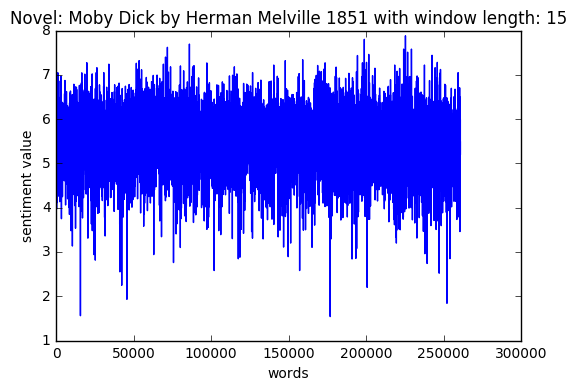

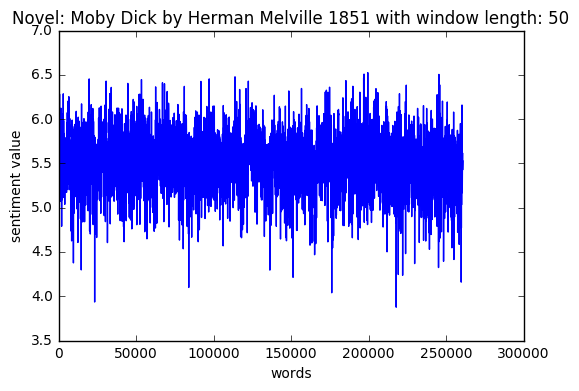

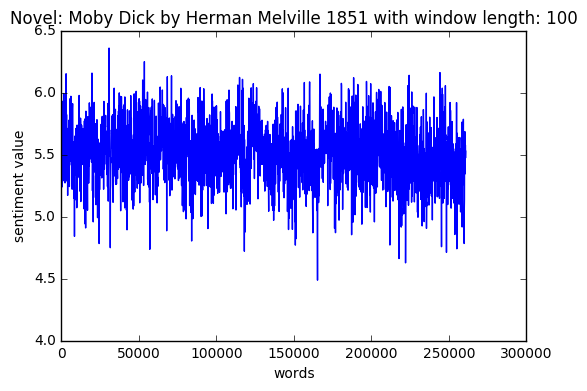

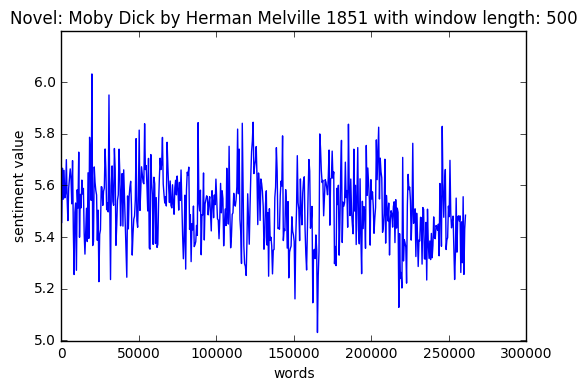

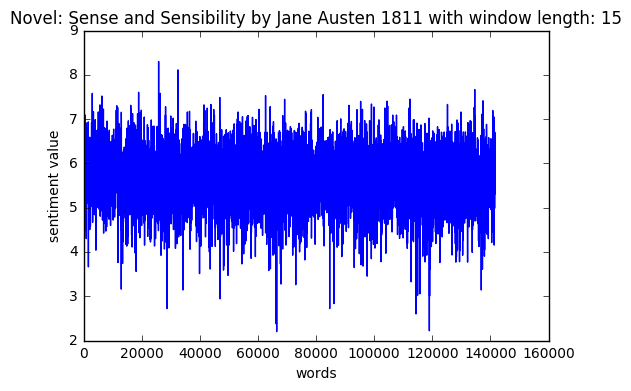

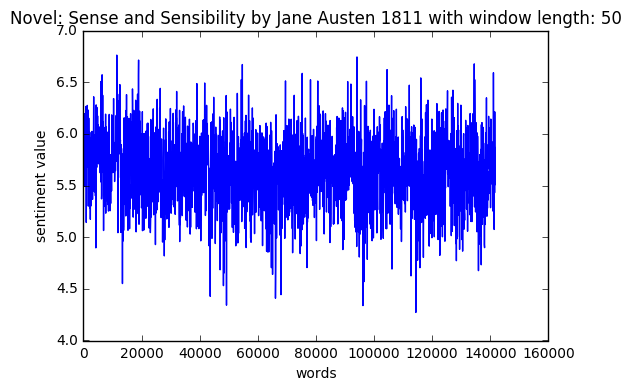

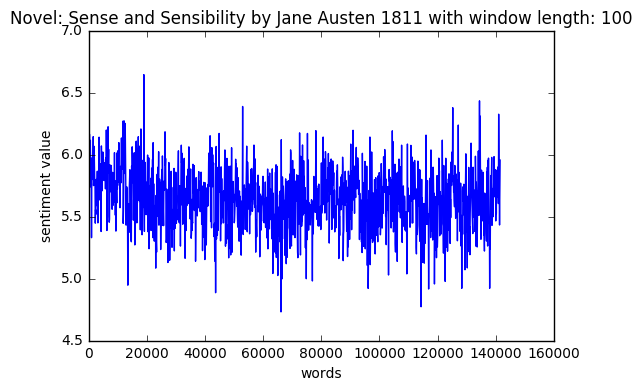

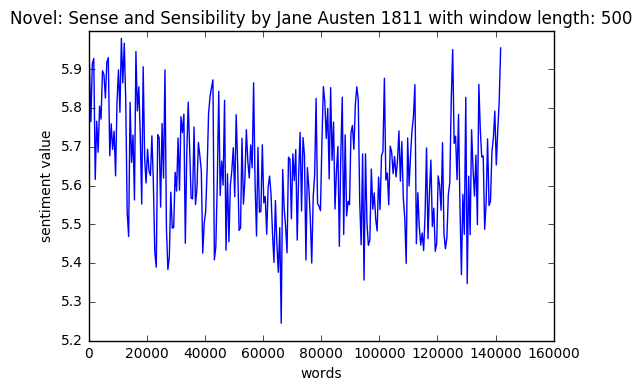

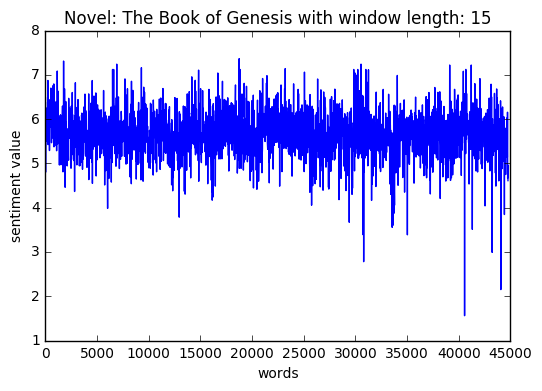

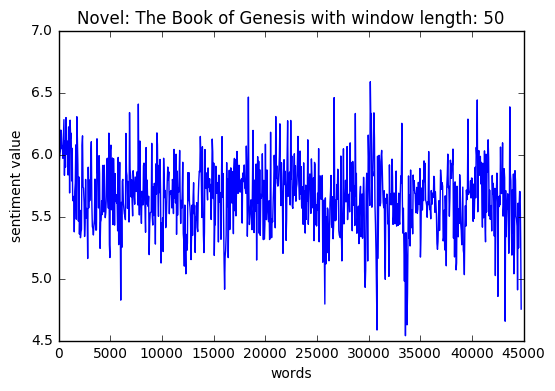

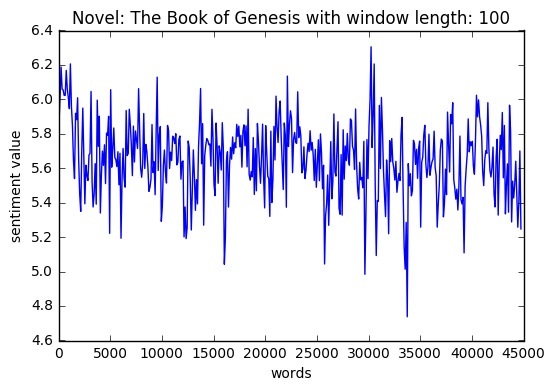

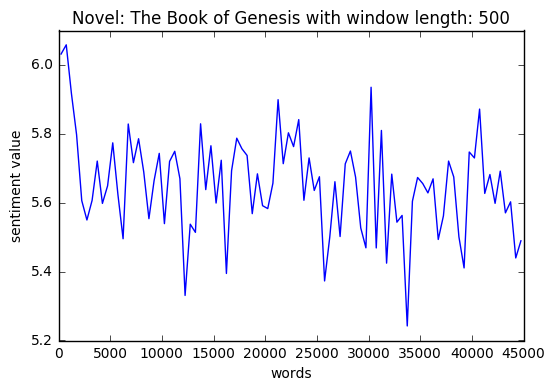

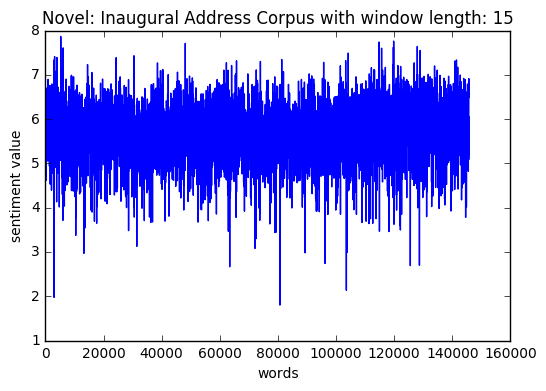

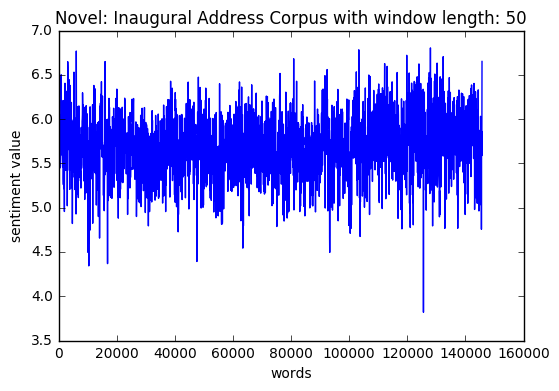

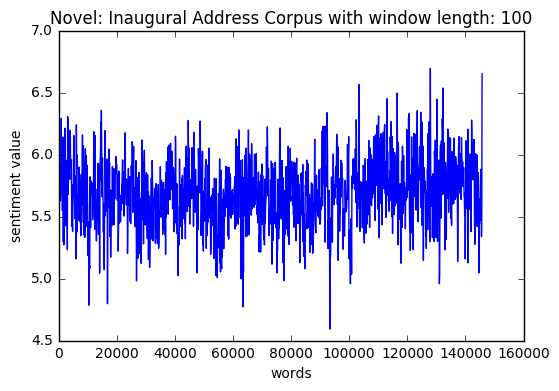

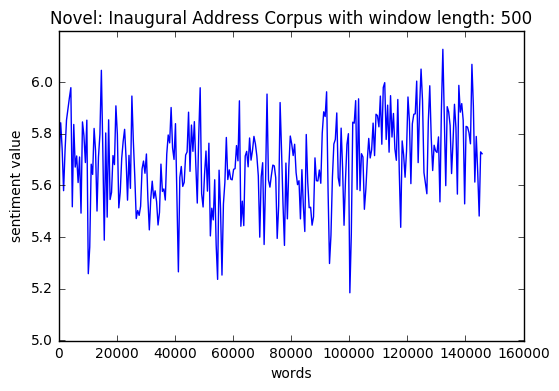

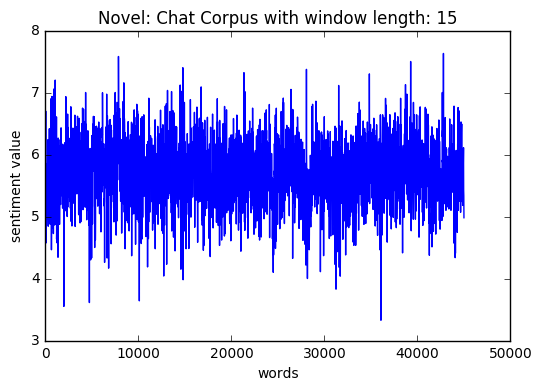

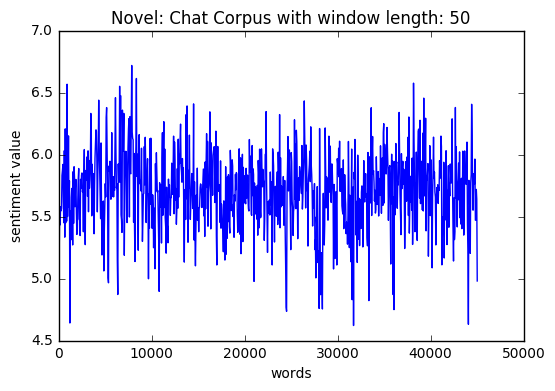

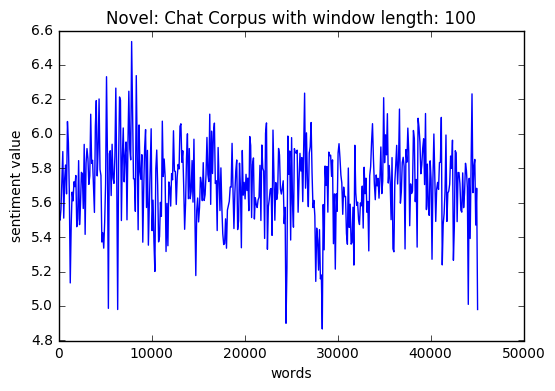

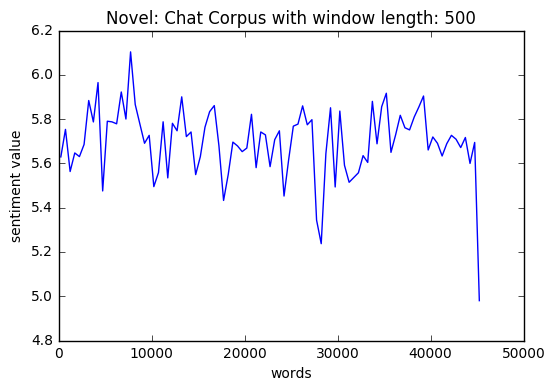

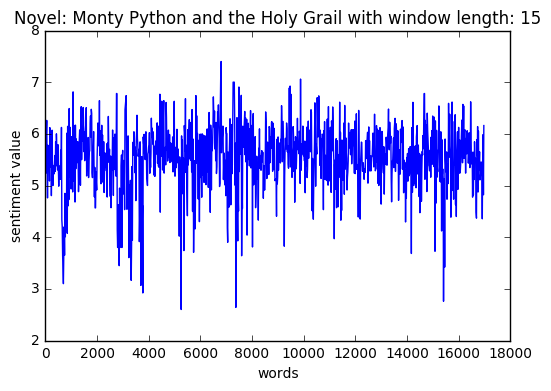

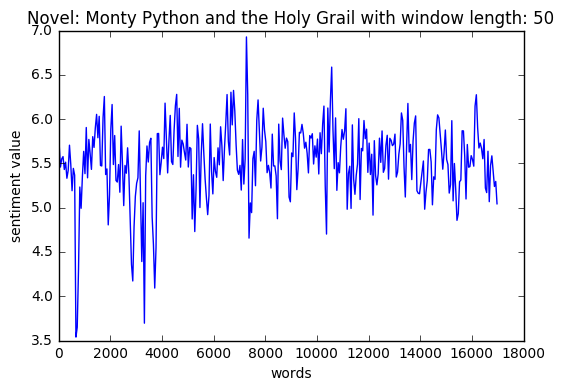

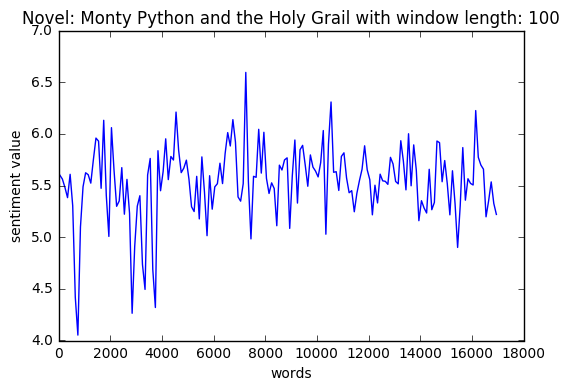

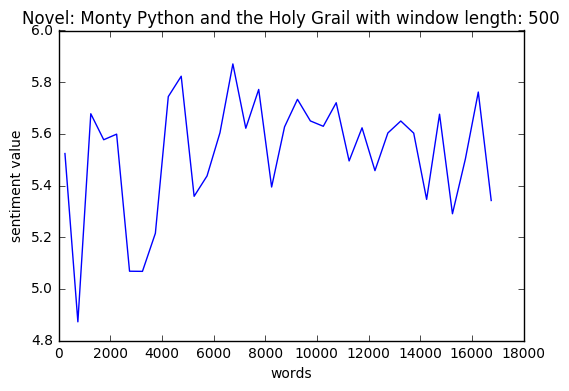

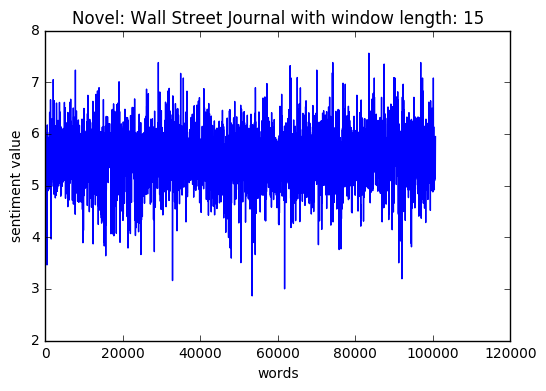

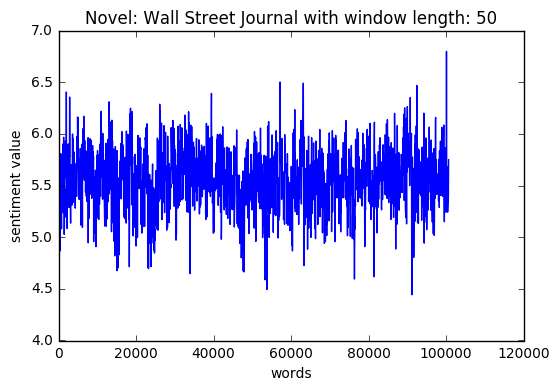

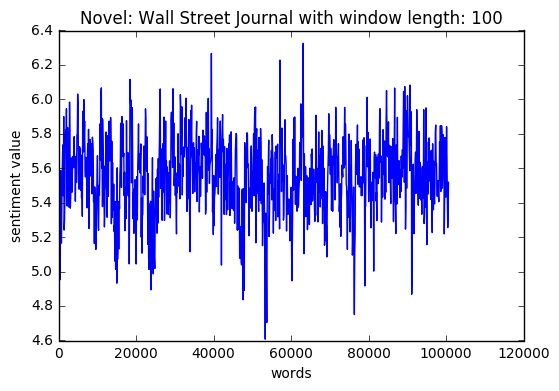

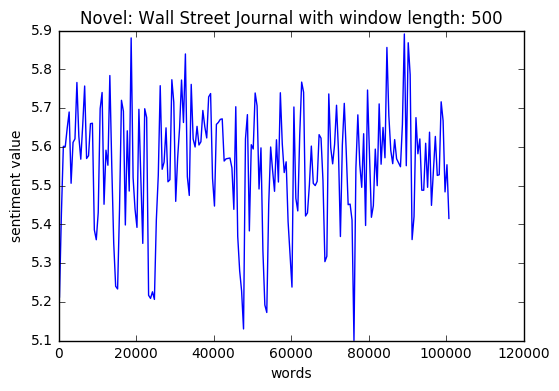

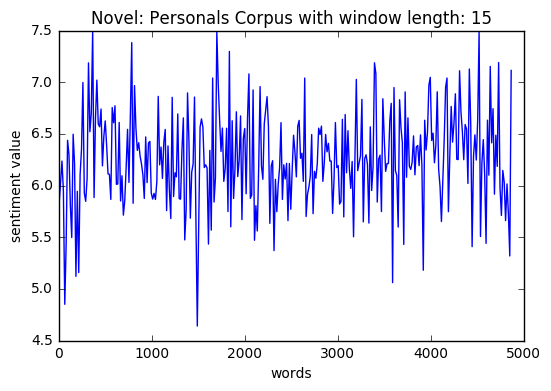

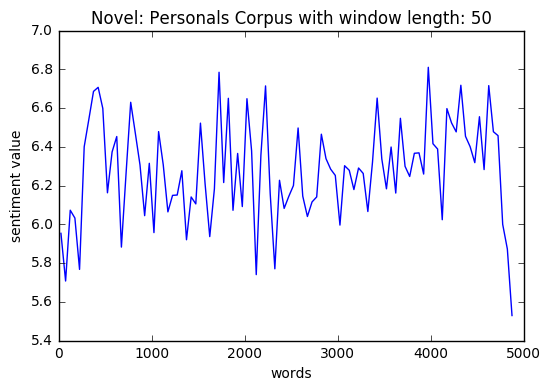

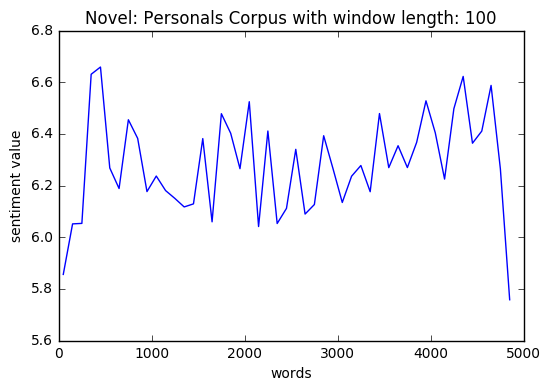

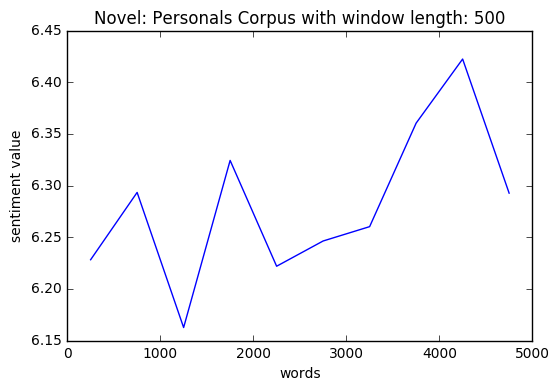

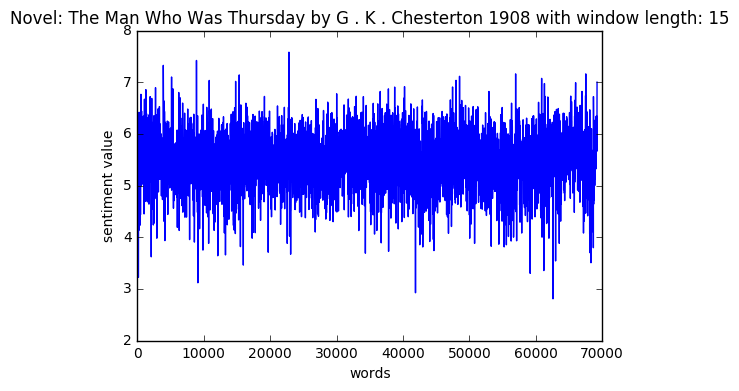

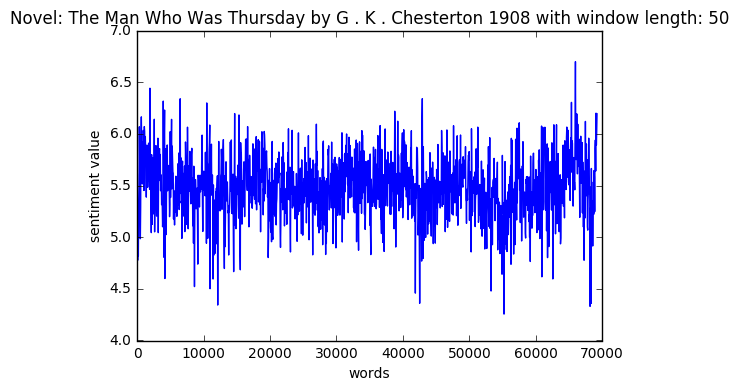

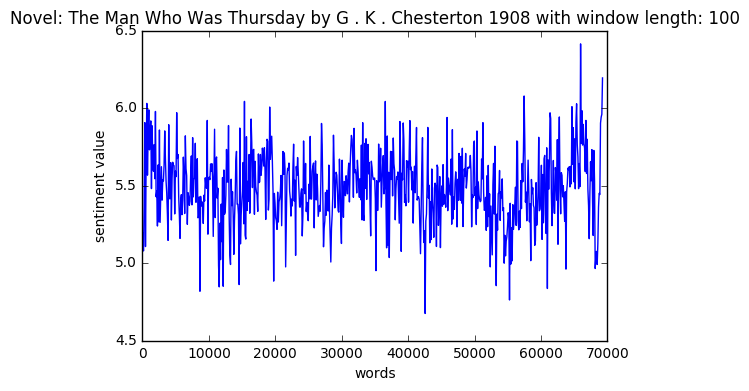

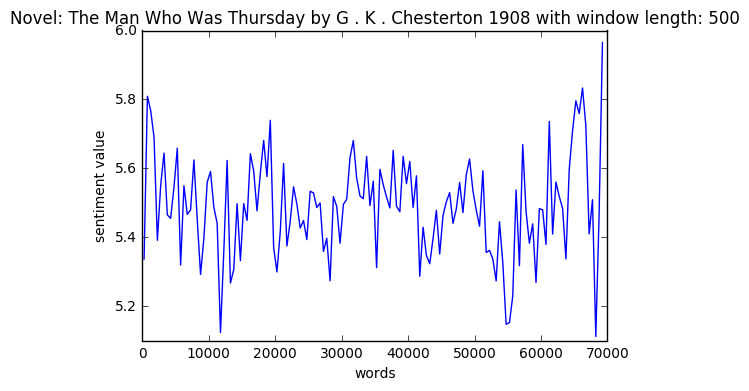

In [258]:
#  moving average to show how the sentiment changes
sliding_windows = [15, 50, 100, 500]

# dicts containing plot values
text_sentiment = dict()
# create plot for each book and windows size
for t in novels:
    for window_size in sliding_windows:
        text_sentiment["novel_{}-window_{}".format(t.name, window_size)] = moving_avg(window_size, t)
        title = 'Novel: {0} with window length: {1}'.format(t.name, window_size)
        plot_sentiment(text_sentiment["novel_{}-window_{}".format(t.name, window_size)], title)

**Question:** Comment on the sentiment profiles. Do they show a similar pattern? What is the effect of changing the size of the sliding window?

**Answer:** The novels differ because they don't share the same size of words. Thus some plots even with a high sliding window value are more dense. In general the plot is more dense when having a small sliding window. That is mainly because there are more data points.

It seems like all novels have different patterns depending on the story line, while there are happy endings in some books the chat corpus and personal corpus show a big decline in happiness in the end. It also seems like that there is usually more significant drops into the negative direction.